# **CQACO: Constrained Quantum Ant Colony Optimization**

QACO is an hybrid quantum algorithm  based on the classical Ant Colony Optimization algorithm to produce
approximate solutions for NP-hard problems, in particular optimization problems. The constrained version of QACO is adapt to problems that have constrained solutions, which specifically means that the numaber of 1's is fixed, a priori.

**Importing libraries and qiskit environment**

In [24]:
# !pip install "qiskit==0.46.0" "qiskit-aer==0.13.3"

In [18]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile

from math import pi, asin, sqrt, cos, sin
from pickle import NONE
import numpy as np
import random
from itertools import combinations
import matplotlib.pyplot as plt
import sys

## **Parameters definition**

In [19]:
# QACO parameters
beta_e0 = 0.13            # Initial exploration probability
maxIter = 62              # Maximum number of iterations
converCondition = 59      # Convergence condition
n = 4                     # Matrix M size; the code is generalized in update_thetas
m = 2                     # Constraint: number of 1s per row and column
problem_matrix = 3        # Choice of problem matrix (1, 2, 3, 4 or 5)

## **Load problem matrices**

In [20]:
import pandas as pd

def load_trial_matrix(problem_matrix):
    """Loads matrix M from CSV file"""
    file_path = f"../Trial_matrices/M{problem_matrix}.csv"
    data = pd.read_csv(file_path, header=None)
    
    M = data.iloc[:4, :].values  # First 4 rows = matrix
    X_th = data.iloc[4, :].values  # Last row = solution vector
    
    return M

In [22]:
# Visualization of matrix M
def plot_matrix(matrix, title="M Matrix Visualization"):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Create a custom color map
    # Negative values -> blue, positive values -> red
    colors = []
    for i in range(matrix.shape[0]):
        color_row = []
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                # Red intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1, 1-intensity, 1-intensity])  # Red with gradations
            elif matrix[i, j] < 0:
                # Blue intensity based on value
                intensity = min(abs(matrix[i, j]) * 2, 1)  # Scale intensity
                color_row.append([1-intensity, 1-intensity, 1])  # Blue with gradations
            else:
                color_row.append([0.9, 0.9, 0.9])  # Light gray for zero
        colors.append(color_row)
    
    # Draw the matrix as image
    im = ax.imshow(colors, aspect='equal')
    
    # Add numerical values in cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Choose text color based on background
            text_color = 'black'
            
            # Format number for better readability
            value_text = f'{matrix[i, j]:.3f}'
            
            ax.text(j, i, value_text, 
                   ha='center', va='center', 
                   color=text_color, 
                   fontsize=14, 
                   fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', 
                           alpha=0.7,
                           edgecolor='none'))
    
    # Customize grid and labels
    ax.set_xlim(-0.5, matrix.shape[1]-0.5)
    ax.set_ylim(-0.5, matrix.shape[0]-0.5)
    
    # Add elegant gridlines
    for i in range(matrix.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=2)
    for j in range(matrix.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=2)
    
    # Axis labels
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels([f'N{i}' for i in range(matrix.shape[1])])
    ax.set_yticklabels([f'N{i}' for i in range(matrix.shape[0])])
    
    # Title and labels
    ax.set_title(title, fontsize=10, fontweight='bold', pad=20)
    ax.set_xlabel('Destination Node', fontsize=8, fontweight='bold')
    ax.set_ylabel('Source Node', fontsize=8, fontweight='bold')
    
    # Remove tick marks for cleaner look
    ax.tick_params(length=0)
    
    plt.tight_layout()
    plt.show()


## **Solution validity check**


In [5]:
def all_valid_solutions(n, m, constrained=True):
    if not constrained:
        return [list(map(int, format(k, f'0{n}b'))) for k in range(2**n)]
    else:
        sols = []
        for combi in combinations(range(n), m):
            vec = [0]*n
            for i in combi:
                vec[i] = 1
            sols.append(vec)
        return sols

## **Fitness and Deterministic Solution**

It is the function

$f(X, M) = X^{\top} M X = \sum_{i=1}^{n} \sum_{j=1}^{i} X_i M_{ij} X_j,\; M_{ij} \in \mathbb{R}.$

to be maximized in the QAP (Quadratica Assignment Problem).


In [6]:
def fitness(x_bits, M):
    #Compute quadratic form x^T M x for binary vector x_bits and matrix M
    x = np.array(x_bits, dtype=float)
    return float(x @ M @ x.T)


In [7]:
# BRUTE FORCE SOLUTION IN F OF M, CALCULATE X_th

def brute_force_min_fitness(M, m):
    n_local = int(M.shape[0])
    solutions = all_valid_solutions(n_local, m, constrained=True)

    best_x = None
    best_f = float("inf")

    for x in solutions:
        f_val = fitness(x, M)
        if f_val < best_f:
            best_f = f_val
            best_x = x

    return best_x, best_f

def brute_force_max_fitness(M, m):
    n_local = int(M.shape[0])
    solutions = all_valid_solutions(n_local, m, constrained=True)

    best_x = None
    best_f = float("-inf")

    for x in solutions:
        f_val = fitness(x, M)
        if f_val > best_f:
            best_f = f_val
            best_x = x

    return best_x, best_f

## **Hamming distance**

The Hamming distance between two strings is the number of places in which the two strings differ.  
The probability of choosing a solution is inversely proportional
to the Hamming distance from the original measurement.

In [8]:
def hamming(a, b):
    return sum(int(ai) != int(bi) for ai, bi in zip(a, b))

def choose_by_inverse_hamming(measured_bits, valid_solutions):
    distances = [hamming(measured_bits, vs) for vs in valid_solutions]
    # avoid division by zero
    inv = [1.0/d if d > 0 else 0.0 for d in distances]
    s = sum(inv)
    if s == 0.0:
        return random.choice(valid_solutions)
    probs = [v/s for v in inv]
    chosen = random.choices(valid_solutions, weights=probs, k=1)[0]
    return list(chosen)

## **Pheromone initialization and new solution exploration**



In [9]:
_lookup_table = {
    (0,0,True): -0.01 * pi,
    (0,0,False): 0.04 * pi,
    (0,1,True): -0.05 * pi,
    (0,1,False): 0.07 * pi,
    (1,0,True): 0.05 * pi,
    (1,0,False): -0.07 * pi,
    (1,1,True): 0.01 * pi,
    (1,1,False): -0.04 * pi             #the condition of cos<0 is implemented later on
}


def init_pheromones(theta_ant):
    #Initialize RY angles θ_i = π/2 for all ant qubits
    theta_ant=[pi/2]*n #n = 4
    return theta_ant

def exploration_angle(beta_e):
    #Compute θ_e = 2 * arcsin(√β_e)
    return 2.0 * asin(sqrt(beta_e))

def calculate_fitness(X, M):
    X = np.array(X, dtype=float)
    return float(X @ M @ X.T)

## **Pheromone update**

In [10]:
def quantum_iteration_circuit_qiskit(theta_ant, theta_e, backend_shots=1, seed=None):

    # Build quantum circuit
    n_local = len(theta_ant)  #4
    qc = QuantumCircuit(n_local + 1, n_local)

    # Prepare ant qubits with RY(theta_i) on qubits 1..n
    for i in range(n_local):
      qc.ry(float(theta_ant[i]), i+1)

    # For each ant qubit: apply exploration RY(theta_e), CX(0,i+1), reset(0), like in Appendix 2
    for i in range(n_local):
      qc.ry(float(theta_e), 0)
      qc.cx(0, i+1)
      qc.reset(0)

    # Measure ant qubits 1..n into classical bits 0..n-1
    for i in range(n_local):
      qc.measure(i+1, i)

    # Execute with AerSimulator
    sim = AerSimulator()
    t_qc = transpile(qc, sim)

    run_args = {"shots": int(backend_shots)}

    if seed is not None:
        run_args["seed_simulator"] = int(seed)
        run_args["seed_transpiler"] = int(seed)

    job = sim.run(t_qc, **run_args)
    result = job.result()
    counts = result.get_counts()

    # Take the most frequent bitstring and ensure it is a normal string
    bitstring = max(counts, key=counts.get)
    if isinstance(bitstring, bytes):
        bitstring = bitstring.decode("utf-8")

    # Keep only 0/1 and reverse (Qiskit returns qubits in reverse order)
    bitstring = ''.join(ch for ch in bitstring if ch in ('0', '1'))
    measured_bits = [int(b) for b in bitstring[::-1]]

    #print("Measured bitstring:", bitstring, "->", measured_bits)
    #print(f"Quantum circuit counts: {counts} \n")
    return measured_bits, counts



def lookup_delta_theta(xi, bi, is_current_better, theta_ant):
    key = (int(xi), int(bi), bool(is_current_better))
    base = _lookup_table[key]
    # "improvement" rows (is_current_better == True) are subject to inversion
    if is_current_better and cos(theta_ant / 2) < 0:
        return -base
    return base

def update_thetas(theta_ant, measured_bits, best_bits, f_x, f_b):

    n = len(theta_ant)

    for i in range(n):
        xi = measured_bits[i]
        bi = 0 if best_bits is None else best_bits[i]
        is_current_better = (f_x > f_b)
        delta = lookup_delta_theta(xi, bi, is_current_better, theta_ant[i])
        theta_new = theta_ant[i] + delta

        # Clip theta_i to [0, pi]
        if theta_new < 0.0:
            theta_new = 0.0
        if theta_new > pi:
            theta_new = pi

        theta_ant[i] = theta_new

    return theta_ant

## **Algorithm**

In the following functions the code is run `n_runs` times in order to calculate error percentage and the mean number of iterations.

In [11]:
def qaco_run_main(M, m, constrained=True, beta_e0=0.13, seed=None, backend_shots=1024, verbose=False): ##############################################

    n = M.shape[0]
    assert M.shape[1] == n
    if constrained:
        from math import comb
        nComb = comb(n, m) #number of all possible combinations between n and m
    else:
        nComb = 2**n


    #rng = np.random.default_rng(seed)
    n = M.shape[0]
    theta_ant=[0]*n
    best_bits=[0]*n

    theta_ant = init_pheromones(theta_ant)
    best_solution = None
    best_fitness = -np.inf

    print(f"QACO run (n={n},, m={m})")
    print(f"converCondition = {converCondition}, maxIter = {maxIter}\n")

    for iter_num in range(1, maxIter + 1):
        # Update beta_e and theta_e to discard suboptimal solutions
        beta_e = beta_e0 + (1.0 - beta_e0) * (iter_num / maxIter)
        theta_e = exploration_angle(beta_e)

        # Store the previous best
        f_prev_best = -np.inf if best_bits is None else calculate_fitness(best_bits, M)

        # Run the quantum circuit (single shot)
        measured_bits, counts = quantum_iteration_circuit_qiskit(theta_ant, theta_e, backend_shots=backend_shots, seed=seed)

        valid_solutions = all_valid_solutions(n, m, constrained=True)

        #If constrained problem and measured invalid -> generate alternative via inverse-hamming
        if constrained:
            if measured_bits not in valid_solutions:
                measured_bits = choose_by_inverse_hamming(measured_bits, valid_solutions)

        # Compute fitness
        fitness = calculate_fitness(measured_bits, M)

        # Update theta_i with the lookup table
        update_thetas(theta_ant, measured_bits, best_bits, fitness, f_prev_best)

        # Update best if needed
        if fitness > best_fitness:
            best_fitness = fitness
            best_bits = measured_bits.copy()
            conver_counter = 0
        else:
            conver_counter += 1

        # Convergence condition
        if conver_counter >= converCondition:
            print("\n Convergence reached!")
            break

        # Print results
        if verbose:
            print(f"Iter {iter_num:3d}: measured={measured_bits} "
                  f"f_x={fitness:.5f} | best_f={best_fitness:.5f} "
                  f"conv={conver_counter}/{converCondition}")

    # Final result
    print("\nFINAL RESULT")
    print("Best solution:", best_bits)
    print("Best fitness :", best_fitness)
    print("Iterations   :", iter_num)
    print("\n")

    return best_bits, iter_num

In [ ]:
def multiple_runs(M, X, n_runs, m, constrained=True):
  # Scan the solution vector and count 1s to set m

  run = 1
  error_count = 0
  sum = 0
  for run in range(n_runs):
      print("Iteraton number: ", run)

      best_bits, iter_num = qaco_run_main(
                M,
                m,
                constrained=constrained
                )
      if X != best_bits:
          error_count += 1

      sum = sum + iter_num
  iter_mean = sum/n_runs
  print(f"Error probability: {((error_count/run)*100):.2f}%")
  print(f"Mean iterations: {iter_mean}")

## **Simulation**

### **Single simulation**

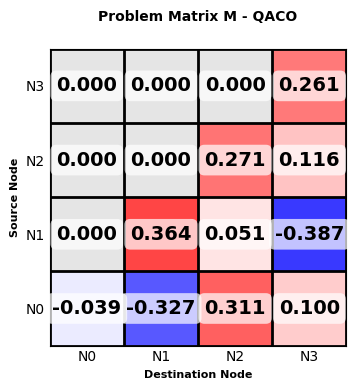

In [23]:
M = load_trial_matrix(problem_matrix)
plot_matrix(M, "Problem Matrix M - QACO")

In [14]:
qaco_run_main(M, 1, constrained=True, beta_e0=0.13, seed=None, backend_shots=1024, verbose=False)

QACO run (n=4,, m=1)
converCondition = 59, maxIter = 62


FINAL RESULT
Best solution: [0, 1, 0, 0]
Best fitness : 0.364
Iterations   : 62




([0, 1, 0, 0], 62)

### **Multiple simulations**

In [15]:
X_th = brute_force_max_fitness(M, m)[0]
X_th  

[0, 1, 1, 0]

In [16]:
multiple_runs(M, X_th, 500, m, constrained=True)

Iteraton number:  0
QACO run (n=4,, m=2)
converCondition = 59, maxIter = 62


 Convergence reached!

FINAL RESULT
Best solution: [0, 1, 1, 0]
Best fitness : 0.6859999999999999
Iterations   : 60


Iteraton number:  1
QACO run (n=4,, m=2)
converCondition = 59, maxIter = 62


FINAL RESULT
Best solution: [0, 1, 1, 0]
Best fitness : 0.6859999999999999
Iterations   : 62


Iteraton number:  2
QACO run (n=4,, m=2)
converCondition = 59, maxIter = 62


 Convergence reached!

FINAL RESULT
Best solution: [0, 1, 1, 0]
Best fitness : 0.6859999999999999
Iterations   : 60


Iteraton number:  3
QACO run (n=4,, m=2)
converCondition = 59, maxIter = 62


FINAL RESULT
Best solution: [0, 1, 1, 0]
Best fitness : 0.6859999999999999
Iterations   : 62


Iteraton number:  4
QACO run (n=4,, m=2)
converCondition = 59, maxIter = 62


 Convergence reached!

FINAL RESULT
Best solution: [0, 1, 1, 0]
Best fitness : 0.6859999999999999
Iterations   : 60


Iteraton number:  5
QACO run (n=4,, m=2)
converCondition = 59, max